<a href="https://colab.research.google.com/github/DietzscheNostoevsky/Learning_Pytorch/blob/main/06_Pytorch_Transfer_learning_ConvNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of pizza, steak and sushi.

# 0. Setup 


Importing required modules and files.  
Using going_modular directory functions.  



In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3812, done.
remote: Counting objects: 100% (455/455), done.
remote: Compressing objects: 100% (251/251), done.
remote: Total 3812 (delta 240), reused 400 (delta 197), pack-reused 3357
Receiving objects: 100% (3812/3812), 650.43 MiB | 17.80 MiB/s, done.
Resolving deltas: 100% (2196/2196), done.
Updating files: 100% (248/248), done.


In [2]:
# Device Agnostic Code 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import os 
import zipfile 
from pathlib import Path
import requests 
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# 1. Getting Data 

## Small 150 Dataset

In [4]:
import os 
import zipfile 
from pathlib import Path
import requests 

# Setup path to data folder 

data_path = Path("data/") # The trailing forward slash (/) in the string 
                          # is used to indicate that it represents a 
                          # directory rather than a specific file. 
                          # It's a common convention to include the trailing slash 
                          # in directory paths to differentiate them from file paths.

image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
# small dataset
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


## Getting larger dataset from Drive

In [41]:
USE_FULL_DATA = True

In [42]:

if USE_FULL_DATA == True:

    # Mount the GDrive
    from google.colab import drive
    drive.mount('/content/drive')

    data_path = Path("data/") # The trailing forward slash (/) in the string 
                            # is used to indicate that it represents a 
                            # directory rather than a specific file. 
                            # It's a common convention to include the trailing slash 
                            # in directory paths to differentiate them from file paths.

    image_path_full = data_path / "pizza_steak_sushi_full"

    if image_path.is_dir():
        print(f"{image_path_full} directory exists.")
    else:
        print(f"Did not find {image_path} directory, creating one...")
        image_path_full.mkdir(parents=True, exist_ok=True)
    zip_data = "/content/drive/Othercomputers/My MacBook Air/GitHub/-Machine_Learning/Learning_Pytorch/pizza_steak_sushi_100_percent.zip"

    with zipfile.ZipFile(zip_data, "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...") 
            zip_ref.extractall(image_path_full)
    train_dir = image_path_full / "train"
    test_dir = image_path_full / "test"
    walk_through_dir(image_path_full)

Mounted at /content/drive
Did not find data/pizza_steak_sushi/test/pizza/714866.jpg directory, creating one...
Unzipping pizza, steak, sushi data...
There are 2 directories and 0 images in 'data/pizza_steak_sushi_full'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_full/train'.
There are 0 directories and 750 images in 'data/pizza_steak_sushi_full/train/pizza'.
There are 0 directories and 750 images in 'data/pizza_steak_sushi_full/train/steak'.
There are 0 directories and 750 images in 'data/pizza_steak_sushi_full/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_full/test'.
There are 0 directories and 250 images in 'data/pizza_steak_sushi_full/test/pizza'.
There are 0 directories and 250 images in 'data/pizza_steak_sushi_full/test/steak'.
There are 0 directories and 250 images in 'data/pizza_steak_sushi_full/test/sushi'.


# 2. Creating Datasets and DataLoaders

 ## 2.2 Creating a transform for torchvision.models (auto creation)

In [50]:
# Get a set of pretrained model weights
weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ConvNeXt_Tiny_Weights.IMAGENET1K_V1

In [51]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[236]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [52]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f1794244d30>,
 ['pizza', 'steak', 'sushi'])

In [53]:
print(len(train_dataloader.dataset))
print(len(test_dataloader.dataset))

2250
750


# 3. Getting Pretrained Model

### 3.2 Setting up a pretrained model

ConvNext_Tiny

In [55]:
weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.convnext_tiny(weights=weights).to(device)
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [16]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        #col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   True
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     4,704                True
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     192                  True
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   True
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     79,296               True
│  

In [56]:
# # Freeze all base layers in the "features" section of the model 
# (the feature extractor) by setting requires_grad=False

for param in model.features.parameters():
    param.requires_grad = False


In [57]:
# Setting manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
OUT_FEATURES = len(class_names)

# Recreate the classifier layer and send it to the target device

# --- GOT THIS FROM SOURCE CODE ----------------------------------

from torch.nn import functional as F
class LayerNorm2d(nn.LayerNorm):
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x =F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 3, 1, 2)
        return x
        
# -------------------------------------

model.classifier = nn.Sequential(
        LayerNorm2d((768,), eps=1e-06, elementwise_affine=True),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=768, out_features=OUT_FEATURES, bias=True)
    ).to(device)

model


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

THE CLASSIFIER LAYER is a match for before freezing the model. 

In [58]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)

summary(model=model, 
         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]) 

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     (192)                False
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     (79,296)             

# 4. Training Model

In [59]:
print(len(train_dataloader))
print(len(test_dataloader))

71
24


In [60]:
# Accuracy 

try:
    from torchmetrics import Accuracy 
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy

accuracy = Accuracy(task="multiclass",
                    num_classes=len(class_names),
                    ).to(device)

print(accuracy)

MulticlassAccuracy()


In [22]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [61]:
# for progress bar
from tqdm.auto import trange, tqdm 

# Training Loop 
# Start seed 

torch.manual_seed(42)
#train_time_start_on_cpu = timer()

# Number of Epochs 
epochs = 20
model_0 = model
# Training and testing loop
results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [] }

for epoch in tqdm(range(epochs)):
    print(F"Epoch: {epoch}\n------")


    train_loss = 0
    train_acc = 0


    for batch, (X,y) in tqdm(enumerate(train_dataloader)):    
                                                       
        X, y = X.to(device), y.to(device)
        model_0.train()

         
        y_pred = model_0(X) 


        loss = loss_fn(y_pred, y) 
        train_loss += loss

        
        optimizer.zero_grad()

        
        loss.backward() 

        
        optimizer.step()
        train_acc  += accuracy(preds=y_pred, target=y )
        
        #if batch%4 == 0:
            #print(F"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} sampples")

    # Average loss per batch, per epoch 
    # Divide total train loss by length of train dataloader 
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)

    # Testing 

    test_loss, test_acc = 0,0
    model_0.eval()

    with torch.inference_mode():
        for X,y in tqdm(test_dataloader):
            X, y = X.to(device), y.to(device)
            # 1. Forward Pass
            test_pred = model_0(X)

            # 2. Calculate loss ( accumutively )
            test_loss += loss_fn(test_pred, y)

            

            test_acc += accuracy(preds=test_pred, target=y )
            
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of the test dataloader ( per batch )
        test_acc /= len(test_dataloader)

    ## print out whats happening 
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    print(f"\nTrain loss: {train_loss:.5f}, Train acc: {train_acc:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.4f}\n")
    
# Calculate Training time 

#train_time_end_on_cpu = timer()
#total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           #end=train_time_end_on_cpu,
                                           #device=str(next(model_0.parameters()).device))


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
------


0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.32331, Train acc: 0.17720 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 1
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.32561, Train acc: 0.18046 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 2
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.32510, Train acc: 0.17579 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 3
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/u


Train loss: 1.32952, Train acc: 0.18151 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 4
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/pyth

  0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Train loss: 1.32494, Train acc: 0.17500 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 5
------


0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.33728, Train acc: 0.16734 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 6
------


0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.32588, Train acc: 0.17544 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 7
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    self._shutdown_workers()
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
:     can only test a child processif w.is_alive():

  File "/usr/lib/

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.33047, Train acc: 0.17342 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 8
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/u

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.32589, Train acc: 0.17711 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 9
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionErrorif w.is_alive():: can only test a child process

  File "/usr/lib/

  0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
AssertionError
: can only test a child process
Exception ignored


Train loss: 1.32339, Train acc: 0.17984 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 10
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():AssertionError
:   File "/usr/lib/python3.10/multiprocessing/pro


Train loss: 1.32322, Train acc: 0.17306 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 11
------


0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.32386, Train acc: 0.16945 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 12
------


0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.31931, Train acc: 0.18829 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 13
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.32358, Train acc: 0.17711 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 14
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.32225, Train acc: 0.17218 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 15
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
can only test a child process    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored 

  0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Train loss: 1.32193, Train acc: 0.17526 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 16
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

  0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored 


Train loss: 1.32236, Train acc: 0.17641 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 17
------


0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.33007, Train acc: 0.16611 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 18
------


0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.32683, Train acc: 0.17870 | Test loss: 1.34487, Test acc: 0.1672

Epoch: 19
------


0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/tor

  0%|          | 0/24 [00:00<?, ?it/s]


Train loss: 1.33060, Train acc: 0.18195 | Test loss: 1.34487, Test acc: 0.1672



In [62]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    loss1 = [i.cpu().detach() for i in loss]
    loss = loss1

    test_loss = results['test_loss']
    test_loss1 = [i.cpu().detach() for i in test_loss]
    test_loss = test_loss1

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    accuracy1 = [i.cpu().detach() for i in accuracy]
    accuracy = accuracy1
    test_accuracy = results['test_acc']
    test_accuracy1 = [i.cpu().detach() for i in test_accuracy]
    test_accuracy = test_accuracy1

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


In [63]:
print(results)

{'train_loss': [tensor(1.3233, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3256, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3251, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3295, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3249, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3373, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3259, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3305, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3259, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3234, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3232, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3239, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3193, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3236, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3222, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3219, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3224, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3301, 

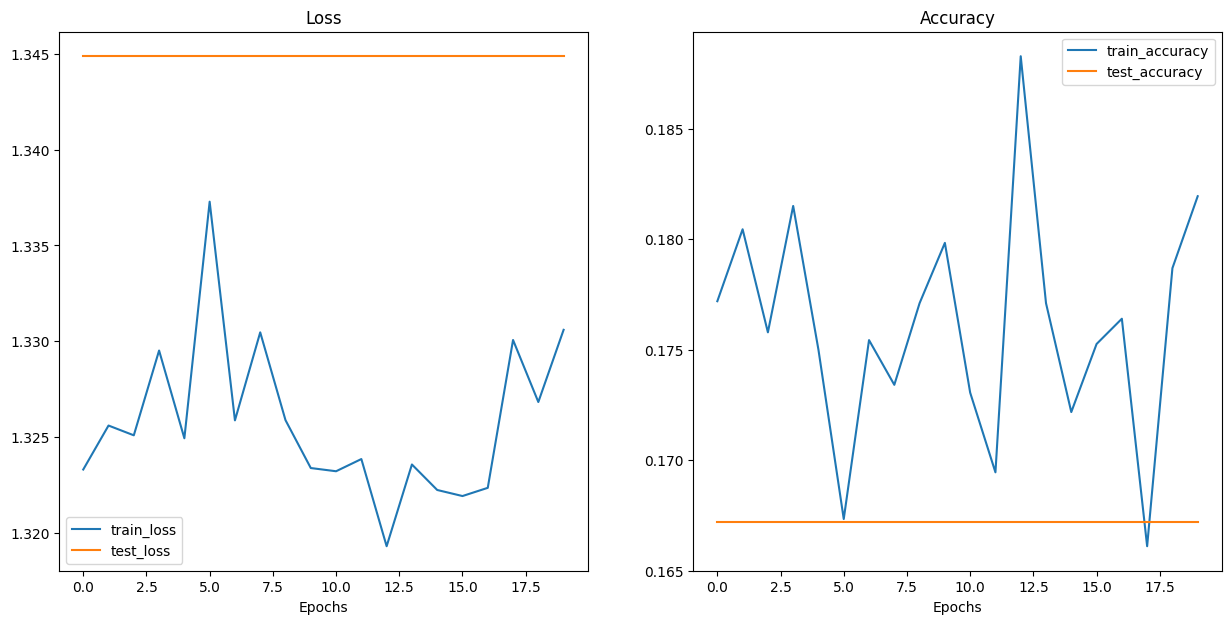

In [64]:
plot_loss_curves(results)

In [65]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3233 | train_acc: 0.1772 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 2 | train_loss: 1.3252 | train_acc: 0.1709 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 3 | train_loss: 1.3289 | train_acc: 0.1761 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 4 | train_loss: 1.3305 | train_acc: 0.1718 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 5 | train_loss: 1.3272 | train_acc: 0.1761 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 6 | train_loss: 1.3257 | train_acc: 0.1722 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 7 | train_loss: 1.3295 | train_acc: 0.1754 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 8 | train_loss: 1.3327 | train_acc: 0.1747 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 9 | train_loss: 1.3302 | train_acc: 0.1749 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 10 | train_loss: 1.3152 | train_acc: 0.1842 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 11 | train_loss: 1.3324 | train_acc: 0.1719 | test_loss: 1.3449 | test_acc: 0.1672
Epoch: 12 | train_l

# 5. Model Evaluation using loss curves 

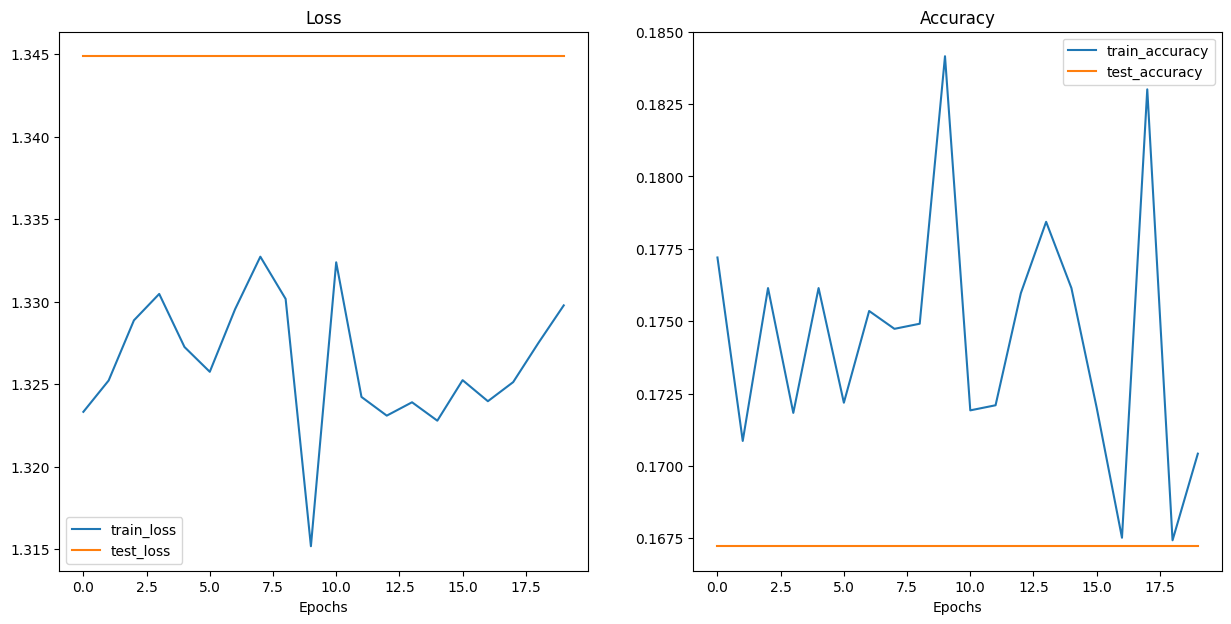

In [66]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# 6. Making predictions in test set

Function to predict and plot

In [67]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

Testing on some random images 

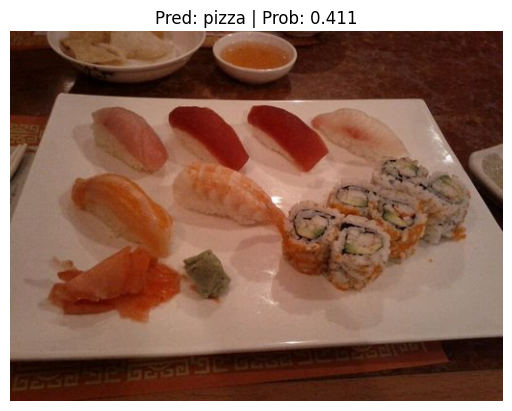

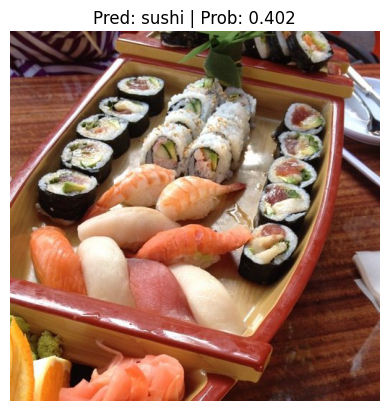

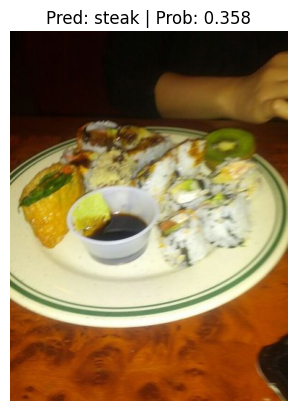

In [68]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

## Making prediction on a custom image 

data/04-pizza-dad.jpeg already exists, skipping download.


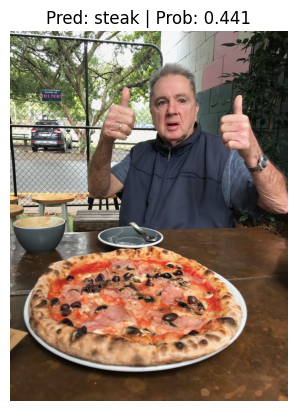

In [69]:

# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

# Exercises

## Confusion Matrix
Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.

Making predictions:   0%|          | 0/24 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f17936a57e0>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

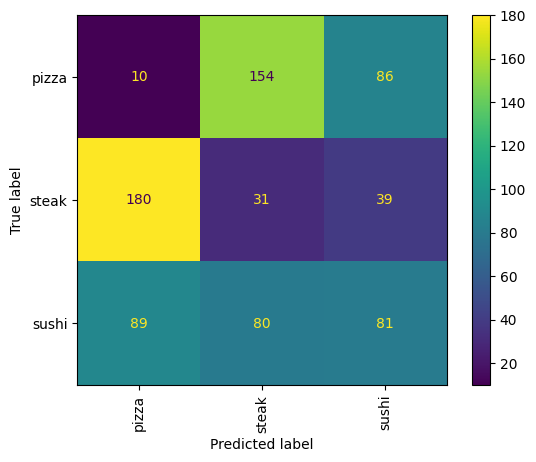

In [70]:

from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

test_truth = torch.cat([y for X, y in test_dataloader])

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_truth, y_pred_tensor, display_labels=class_names,xticks_rotation="vertical")
plt.show()


## Most Wrong 
* Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:  
    * Predicting across all of the test dataset, storing the labels and predicted probabilities.  
    * Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest   prediction probabilities, in other words, the "most wrong".  
    * Plot the top 5 "most wrong" images, why do you think the model got these wrong?  

### Solution 

* Want to:

    * Create a DataFrame with sample, label, prediction, pred prob  
    * Sort DataFrame by correct (does label == prediction)
    * Sort DataFrame by pred prob (descending)
    * Plot the top 5 "most wrong"

In [71]:

# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model,
                                 transform=manual_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/750 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_full/test/pizza/1594097.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.47281551361083984,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_full/test/pizza/1895182.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4147815406322479,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_full/test/pizza/897300.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4125863015651703,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_full/test/pizza/3784357.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4217333495616913,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi_full/test/pizza/771336.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.46635907888412476,
  'pred_class': 'sushi',
  'correct': False}]

In [72]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

image_path class_name  pred_prob  \
701  data/pizza_steak_sushi_full/test/sushi/913716.jpg      sushi   0.820601   
673  data/pizza_steak_sushi_full/test/sushi/2012780...      sushi   0.758395   
601  data/pizza_steak_sushi_full/test/sushi/1891961...      sushi   0.757057   
562  data/pizza_steak_sushi_full/test/sushi/621419.jpg      sushi   0.720462   
252  data/pizza_steak_sushi_full/test/steak/2756200...      steak   0.681180   

    pred_class  correct  
701      steak    False  
673      steak    False  
601      steak    False  
562      steak    False  
252      pizza    False

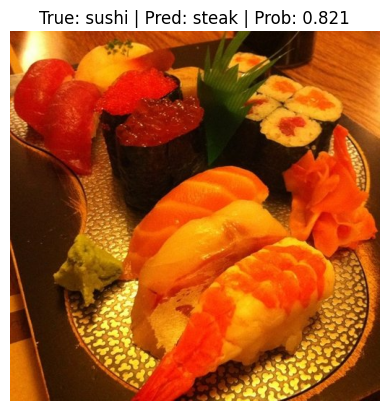

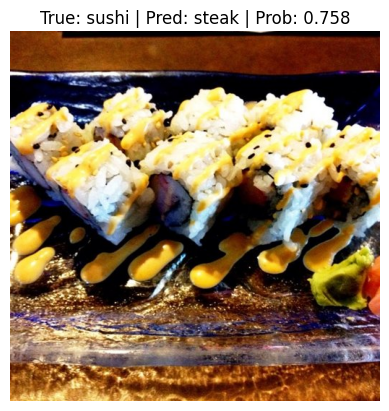

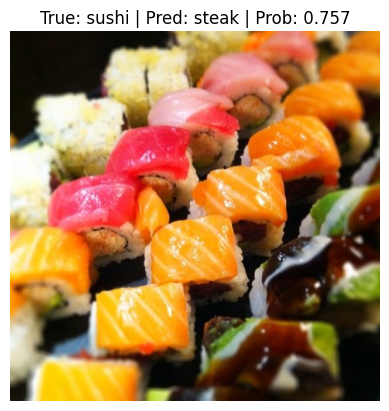

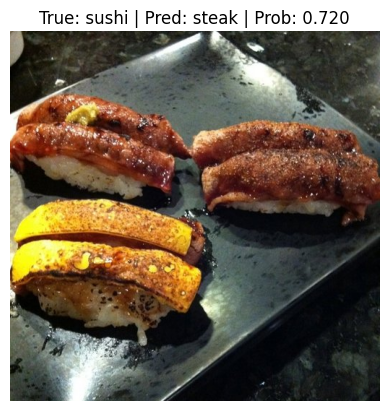

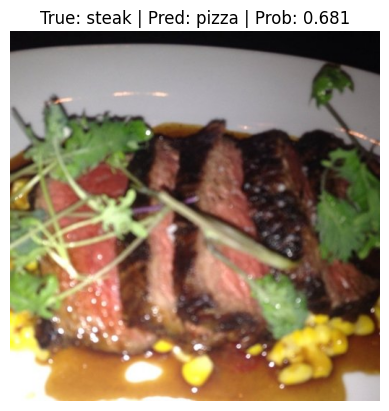

In [73]:

import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

## Own Image prediction

Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

### Solution

#### Function to plot and predict image

In [74]:

# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)
  
  # plot image and pred
  plt.figure() 
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);



#### Pizza

--2023-05-25 08:05:36--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 199.232.46.208, 2a04:4e42:48::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.46.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4343742 (4.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a.1’

photo-1588315029754 100%[===================>]   4.14M  --.-KB/s    in 0.01s   

2023-05-25 08:05:36 (328 MB/s) - ‘photo-1588315029754-2dd089d39a1a.1’ saved [4343742/4343742]



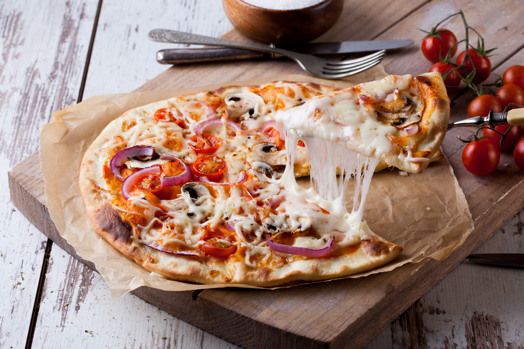

In [75]:
# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a 
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized

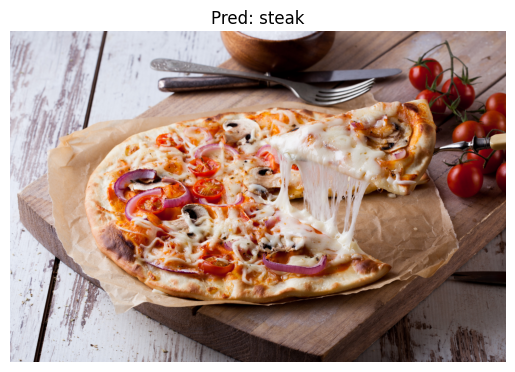

In [76]:
pred_and_plot(image_path="pizza.jpg",
              model=model,
              transform=manual_transforms,
              class_names=class_names)

#### Steak

--2023-05-25 08:05:40--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 199.232.46.208, 2a04:4e42:48::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.46.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13559943 (13M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef.1’

photo-1546964124-0c 100%[===================>]  12.93M  --.-KB/s    in 0.1s    

2023-05-25 08:05:40 (96.1 MB/s) - ‘photo-1546964124-0cce460f38ef.1’ saved [13559943/13559943]



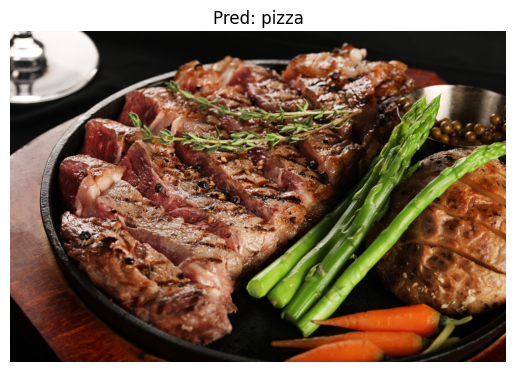

In [77]:
# Try again on a photo of steak from unsplash.com 
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

pred_and_plot("steak.jpg",
              model=model,
              transform=manual_transforms,
              class_names=class_names)

#### Apple

--2023-05-25 08:05:48--  https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
Resolving images.unsplash.com (images.unsplash.com)... 199.232.46.208, 2a04:4e42:48::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.46.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6876691 (6.6M) [image/jpeg]
Saving to: ‘photo-1570913149827-d2ac84ab3f9a.1’

photo-1570913149827 100%[===================>]   6.56M  --.-KB/s    in 0.03s   

2023-05-25 08:05:48 (257 MB/s) - ‘photo-1570913149827-d2ac84ab3f9a.1’ saved [6876691/6876691]



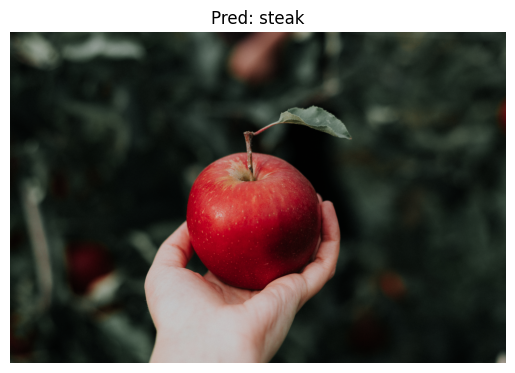

In [78]:
# Get an image of not pizza/steak/sushi
!wget https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
!cp photo-1570913149827-d2ac84ab3f9a apple.jpg 

pred_and_plot(image_path="apple.jpg",
              model=model,
              transform=manual_transforms,
              class_names=class_names)